In [5]:
from src.data.datasets import SiteDataset
import jax.numpy as jnp
site_data = SiteDataset("5a0546857ecc773753327266")

floor = site_data.floors[0]
trace = floor.traces[0]
matrices = trace.matrices
position = matrices["position"]
wifi = matrices["wifi"]
from numpyro import handlers
import numpyro.distributions as dist
from numpyro import sample, plate
import numpyro
from jax import lax
import numpy as np

In [6]:
height, width = floor.info["map_info"]["height"], floor.info["map_info"]["width"]
floor_uniform = dist.Independent(
    dist.Uniform(low=jnp.array([0, 0]), high=jnp.array([height, width])), 1
)
floor_uniform2 = dist.Independent(
    dist.Uniform(low=jnp.array([-1/2, -1/2]), high=jnp.array([1/2, 1/2])), 1
)


In [7]:
def f(carry, noise_t):
  x_pre,sigma = carry
  x_t = x_pre + sigma*noise_t
  x_pre = x_t
  return (x_pre, sigma), x_t

In [9]:
def initial_model(wifi,wifi_is_observed, position=None, pos_is_observed=None, pos_is_not_observed=None):
    #T = position.shape[0]
    T = wifi.shape[0]
    K = wifi.shape[1]
    
    pos_observed = None if position is None else position[pos_is_observed]

    sigma_eps = 0.1/200
    sigma = 0.1/200

    mu_omega_0 = max_wifi#/200
    sigma_omega_0 = 2#/200
    sigma_omega = 0.02/(max_wifi-min_wifi)

    x = jnp.zeros((T, 2))

    #x0 = sample("x_0", floor_uniform)
    x0 = sample("x_0", floor_uniform2)

    noises = sample("noises", fn=dist.Normal(0, 1), sample_shape=(T - 1, 2))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (x0, sigma)
    x_collection = [x0]
    carry, x = lax.scan(f, carry, noises, T - 1)
    x = jnp.concatenate((jnp.array(x_collection), x), axis=0)

    x_hat = sample(
        name="x_hat",
        fn=dist.Normal(loc=x[pos_is_observed], scale=sigma_eps),
        obs=pos_observed,
    )


    with plate("wifis", K):
        omega_0 = sample("omega_0", dist.Normal(mu_omega_0, sigma_omega_0))
        wifi_locations = sample("wifi_location", floor_uniform2)

    distance = ((wifi_locations-jnp.tile(x,(len(wifi_locations),1,1)).transpose((1,0,2)))**2).sum(-1)
    signal_strength=jnp.tile(omega_0,(T,1))[wifi_is_observed] - jnp.log(distance[wifi_is_observed])-2*jnp.log(200)
    #print(omega_0,distance,(signal_strength))
    omega = sample(
            name="omega",
            fn=dist.Normal(loc=(signal_strength-min_wifi)/(max_wifi-min_wifi)-0.5, scale=sigma_omega),
            obs=wifi[wifi_is_observed]
    )

In [10]:
with handlers.seed(rng_seed=0):
    initial_model(wifi3,wifi_is_observed)

NameError: name 'wifi3' is not defined

In [12]:
def s_strength(WIFI_loc0,WIFI_loc1, X):
    norm = np.sqrt((WIFI_loc0-X[0])**2+(WIFI_loc1-X[1])**2)
    return max_wifi+10-2*np.log(norm*200*np.sqrt(2))

In [4]:
H_factor = (width-height)/height+1

NameError: name 'width' is not defined

In [287]:
H_factor

1.3217469385243366

In [20]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt


delta = 0.025
x = np.arange(-0.5, 0.5, delta)
y = np.arange(-0.5*H_factor, 0.5*H_factor, delta)
X, Y = np.meshgrid(x, y)

Z = s_strength( X,Y, np.array([0.5,-0.5]))


NameError: name 'H_factor' is not defined

NameError: name 'Z' is not defined

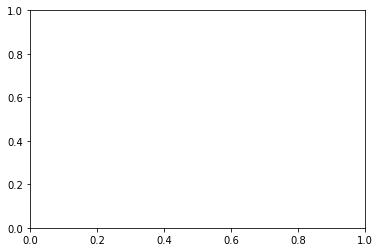

In [21]:
fig, ax = plt.subplots()
levels = np.logspace(np.log(np.min(Z)),np.log(np.max(Z)), 100)
levels = np.linspace(np.min(Z),np.max(Z), 100)
CS = ax.contour(X, Y, Z, levels = levels)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Signal strength')

In [13]:
#wifi = np.nan_to_num(wifi)
wifi2 = wifi.copy()
wifi2[wifi2<-85] = np.nan

In [14]:
wifi = wifi[:,~np.isnan(wifi2).all(axis=0)]


In [15]:
min_wifi = min(wifi[~np.isnan(wifi)])
max_wifi =max(wifi[~np.isnan(wifi)]) 
wifi3 = (wifi- min_wifi) / (max_wifi-min_wifi)-0.5
print(min_wifi,max_wifi)

-90.0 -51.0


In [16]:
max(wifi3[~np.isnan(wifi)])

0.5

In [17]:
wifi.shape

(334, 103)

In [18]:
import time
from jax import random, vmap
from numpyro.infer import MCMC, NUTS
import numpy as np

t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

pos_is_observed = ~jnp.isnan(position[:, 0])
pos_is_not_observed = jnp.isnan(position[:, 0])
wifi_is_observed = ~jnp.isnan(wifi3)

position2 = position / np.array([width,height])[None,:]-0.5

numpyro.set_host_device_count(4)

nuts_kernel = NUTS(model=initial_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(
    rng_key_,
    wifi=jnp.array(wifi3),
    wifi_is_observed = wifi_is_observed,
    position=jnp.array(position2),
    pos_is_not_observed=pos_is_not_observed,
    pos_is_observed=pos_is_observed,
)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0) / 60))


KeyboardInterrupt: 

In [ ]:
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
         noises[0,0]     -0.16      1.20      0.01     -1.69      1.05      2.00 287847.91
         noises[0,1]      0.45      1.12      0.31     -0.67      1.86      2.00 244188.92
         noises[1,0]     -0.23      0.79     -0.33     -1.15      0.89      2.00 428546.66
         noises[1,1]      0.21      1.24      0.80     -1.91      1.16      2.00 393749.31
         noises[2,0]     -0.61      1.21     -1.08     -1.67      1.41      2.00 437366.84
         noises[2,1]      0.42      1.32      0.65     -1.53      1.90      2.00 217616.95
         noises[3,0]     -0.24      0.60     -0.34     -0.87      0.60      2.00 314519.94
         noises[3,1]      1.16      0.23      1.17      0.85      1.45      2.00  42529.53
         noises[4,0]      0.73      0.78      0.46     -0.04      2.02      2.00 544248.56
         noises[4,1]      0.45      0.48      0.41     -0.14      1.11      2.00 566711.0

In [ ]:
hmc_samples2 = {k: v for k, v in mcmc.get_samples().items()}
X2 = hmc_samples2["x_0"] + jnp.cumsum(hmc_samples2["noises"], axis = 1).transpose((1,0,2))*0.1/200

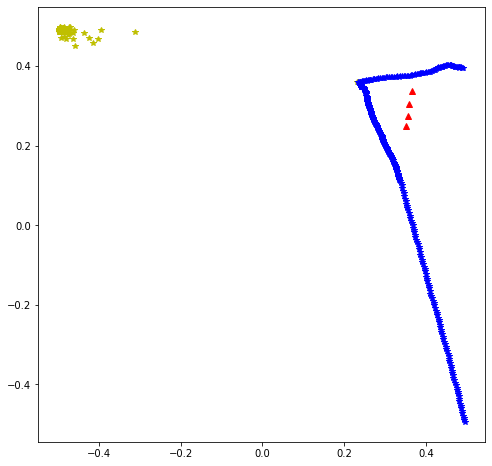

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(*jnp.mean(hmc_samples2["wifi_location"], axis = 0).T, "y*")
plt.plot(*jnp.mean(X2, axis=1).T, 'b*')
plt.plot(*position2[pos_is_observed].T, 'r^')
plt.show()

In [ ]:
len(jnp.mean(hmc_samples2["wifi_location"], axis = 0))

62

## Prediction

In [ ]:
from numpyro.infer import Predictive

In [ ]:
 predictive(random.PRNGKey(1), jnp.array(wifi2))

{'noises': DeviceArray([[[-1.8741734 , -0.37198123],
               [ 0.15325564,  2.748518  ],
               [-1.1531812 , -0.16255577],
               ...,
               [ 0.37757868, -0.01572735],
               [ 0.3648971 ,  0.63837546],
               [-1.569876  , -1.3239739 ]],
 
              [[-0.45637745, -0.66470236],
               [-0.54539376, -0.21375754],
               [-0.60648006,  0.10640739],
               ...,
               [ 0.37116858, -0.53916925],
               [ 0.12408159, -0.831645  ],
               [ 0.34983933, -0.45687714]],
 
              [[ 0.72540194,  1.3614142 ],
               [ 0.80761945,  1.2154298 ],
               [ 0.59116524,  0.30199012],
               ...,
               [-1.1976418 ,  0.16862944],
               [ 0.5993    ,  0.31810212],
               [ 1.0015358 ,  0.28330746]],
 
              ...,
 
              [[ 0.8175271 ,  0.29959285],
               [-1.27896   ,  1.4648314 ],
               [ 0.41329265, -0.40872115

In [ ]:
wifi

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
wifi2

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
predictive = Predictive(initial_model, hmc_samples2, return_sites=["x_0","noises"])
noises = predictive(random.PRNGKey(1), jnp.array(wifi2))[
    "noises"
]
x_0 = predictive(random.PRNGKey(1), jnp.array(wifi2))[
    "x_0"
]

In [ ]:
X3 = x_0 + jnp.cumsum(noises, axis = 1).transpose((1,0,2))*0.1/200

In [ ]:
sum(sum(X3!=X2))

array([0, 0])

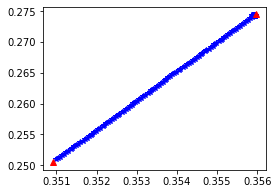

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(*jnp.mean(X3, axis=1).T, 'b*')
plt.plot(*position2[pos_is_observed].T, 'r^')
plt.show()

In [ ]:
from numpyro.infer import Predictive
#initial_model(wifi, position=None, pos_is_observed=None, pos_is_not_observed=None):


predictive = Predictive(initial_model, guide=guide, num_samples=1000,
                        return_sites=("x_hat", "noises"))
samples = predictive(X_train_torch, y_train_torch)

NameError: name 'model' is not defined

In [ ]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
X = hmc_samples["x_0"] + jnp.cumsum(hmc_samples["noises"], axis = 1).transpose((1,0,2))*0.1

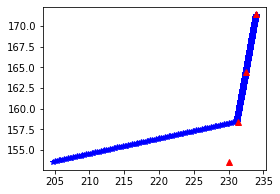

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.plot(*jnp.mean(X, axis=1).T, 'b*')
plt.plot(*position[pos_is_observed].T, 'r^')
plt.show()